In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import warnings

In [2]:
warnings.simplefilter(action='ignore')

In [3]:
def get_distribution(cat_var, data):
    #A column named 'count' containing the count of each category is created
    distribution_df = pd.DataFrame(data[cat_var].value_counts())
    total = distribution_df['count'].sum()
    total_row_df = pd.DataFrame([[total]], index=['Total'], columns=['count'])
    distribution_df = pd.concat([distribution_df, total_row_df], axis=0)
    distribution_df['Percentage'] = distribution_df['count']/total

    return distribution_df

In [4]:
data = pd.read_excel('Candidate_TS_Sample.xlsx')
data.head()

,period,ordered_revenue_sales,ordered_units_sales
0,2021-03-28,709201.27,3582
1,2022-04-03,108596.50,590
2,2022-03-27,158542.60,894
3,2021-06-27,363364.36,2002
4,2022-05-15,157427.93,801


In [5]:
data.dtypes

period                   datetime64[ns]
ordered_revenue_sales           float64
ordered_units_sales               int64
dtype: object

In [6]:
data = data.sort_values(by='period').reset_index(drop=True)
data.head()

,period,ordered_revenue_sales,ordered_units_sales
0,2021-02-21,676248.33,3599
1,2021-02-28,627220.77,3156
2,2021-03-07,644602.92,3240
3,2021-03-14,1237135.22,7332
4,2021-03-21,885036.99,4603


In [7]:
#Extract Month and Year
data['Day'] = data['period'].apply(lambda date: date.day)
data['Month'] = data['period'].apply(lambda date: date.month)
data['Year'] = data['period'].apply(lambda date: date.year)
data.head()

,period,ordered_revenue_sales,ordered_units_sales,Day,Month,Year
0,2021-02-21,676248.33,3599,21,2,2021
1,2021-02-28,627220.77,3156,28,2,2021
2,2021-03-07,644602.92,3240,7,3,2021
3,2021-03-14,1237135.22,7332,14,3,2021
4,2021-03-21,885036.99,4603,21,3,2021


In [8]:
#Weekly Data
start_week = 0

def create_week_indicator(day):
    '''
    The start_week will count the weeks in a continuous manner for the ordered period.
    '''
    global start_week
    start_week += day//7
    return start_week

data['Week'] = list(range(1, data.shape[0]+1))
del start_week
data[['Week']].describe()

,Week
count,65.00000
mean,33.00000
std,18.90767
min,1.00000
25%,17.00000
50%,33.00000
75%,49.00000
max,65.00000


In [9]:
data.dtypes

period                   datetime64[ns]
ordered_revenue_sales           float64
ordered_units_sales               int64
Day                               int64
Month                             int64
Year                              int64
Week                              int64
dtype: object

In [10]:
def plotting(X_var, y_var, category_var, data):
    '''
    Input:
    X_var:-
    y_var:-
    year_list
    '''
    fig, ax = plt.subplots()
    value_list = list(set(data[category_var]))
    for value in value_list:
        df = data.loc[data[category_var]==value, :]
        ax.plot(df[X_var], df[y_var], label=value)   
    
    ax.legend(value_list)
    plt.title('Trend_Analysis')
    plt.xlabel(X_var)
    plt.ylabel(y_var)
    plt.show()

In [11]:
#Monthly revenue
month_grp = data.groupby(['Year', 'Month'])
monthly_revenue = pd.DataFrame(month_grp.apply(lambda df: df['ordered_revenue_sales'].sum()), columns=['Total_Revenue'])
monthly_revenue.reset_index(inplace=True)

#Revenue in Millions
monthly_revenue['Total_Revenue(Millions)'] = monthly_revenue['Total_Revenue'].apply(lambda revenue:round(revenue/(10**6), 3))

#Monthly sales
monthly_units = pd.DataFrame(month_grp.apply(lambda df: df['ordered_units_sales'].sum()), columns=['Total_Units'])
monthly_units.reset_index(inplace=True)


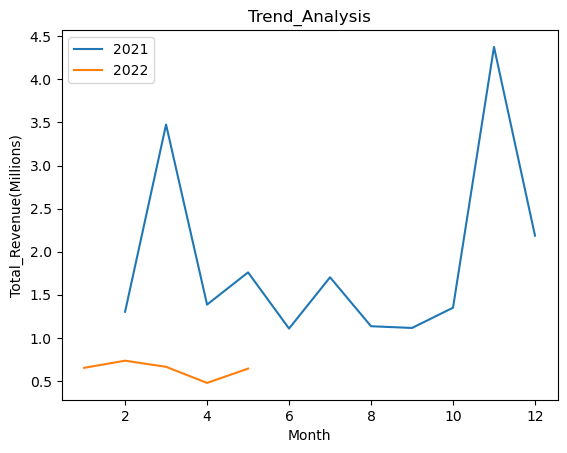

In [12]:
#Month Wise Total Revenue
plotting(X_var='Month', y_var='Total_Revenue(Millions)', category_var='Year', data=monthly_revenue)
    

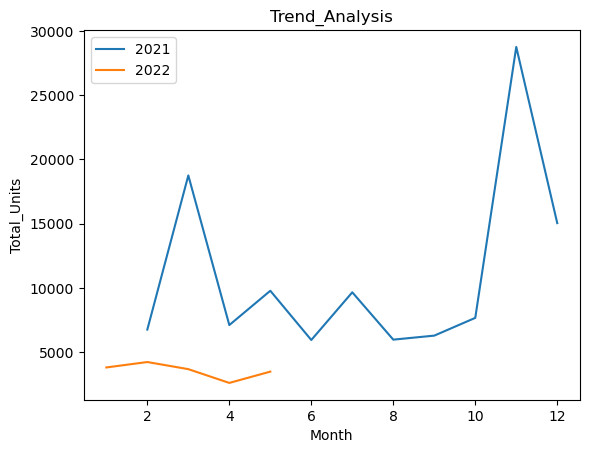

In [13]:
#Month wise ordered_units_sales
plotting(X_var='Month', y_var='Total_Units', category_var='Year', data=monthly_units)

## Week Wise Trends

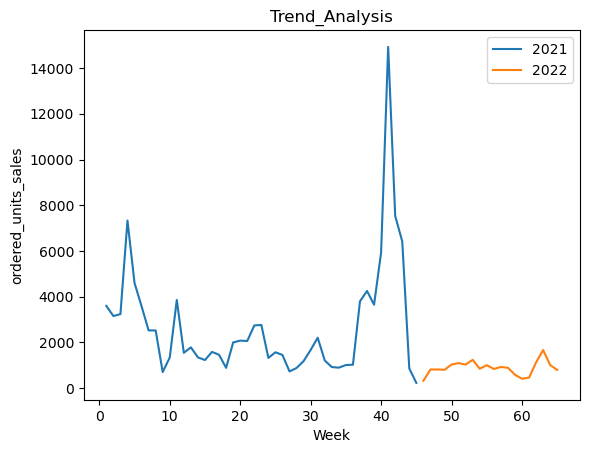

In [14]:
plotting(X_var='Week', y_var='ordered_units_sales', category_var='Year', data=data)

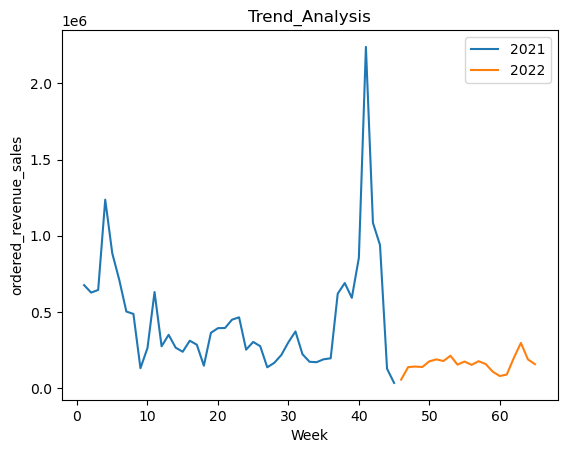

In [15]:
#ordered_revenue_sales
plotting(X_var='Week', y_var='ordered_revenue_sales', category_var='Year', data=data)

## Applying Smoothing

Moving Average

In [16]:
previous_sum  = 0
def get_sum(start, batch_size):
    global previous_sum, value_list
    if(start<batch_size):
        previous_sum += value_list[start]

    else:
        previous_sum -= value_list[start-batch_size]
        previous_sum += value_list[start]

    return previous_sum 

In [17]:
def compute_moving_average(forecast_var, data, batch_size=7):
    '''
    For each week compute the average of foracast variable for the next 'batch_size' (default 7) weeks.
    
    Input:
    forecast_var:- The the variable to be smoothed. Compute average as a smoothing technique.
    batch_size:- The number of entries to be considered for smoothing.

    Return:-
    The variable after smoothing
    '''
    global value_list
    start = 0
    end = data.shape[0]
    previous_sum = 0
    value_list = data[forecast_var].tolist()
    cumulative_sum = [get_sum(start_ind, batch_size) for start_ind in range(len(value_list))]
    data[forecast_var + '_Cumm_Sum'] = cumulative_sum
    data[forecast_var + '_Moving_Avg'] = data[forecast_var + '_Cumm_Sum']/batch_size
    
    return forecast_var + '_Cumm_Sum', forecast_var + '_Moving_Avg'

In [18]:
compute_moving_average(forecast_var='ordered_revenue_sales', data=data)

('ordered_revenue_sales_Cumm_Sum', 'ordered_revenue_sales_Moving_Avg')

In [19]:
compute_moving_average(forecast_var='ordered_units_sales', data=data)


('ordered_units_sales_Cumm_Sum', 'ordered_units_sales_Moving_Avg')

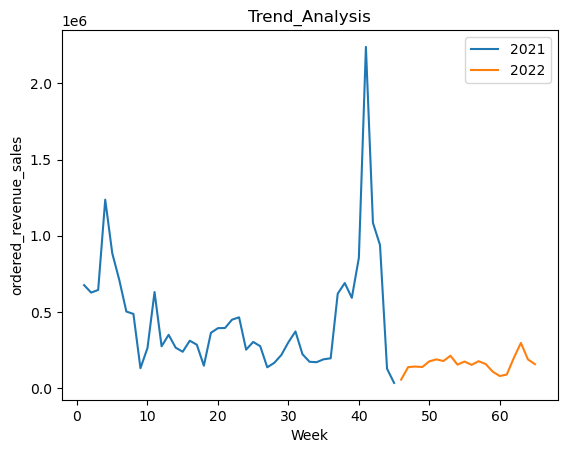

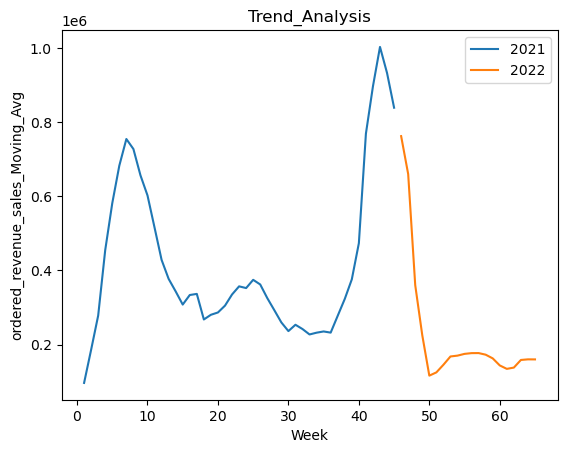

In [20]:
plotting(X_var='Week', y_var='ordered_revenue_sales', category_var='Year', data=data)
plotting(X_var='Week', y_var='ordered_revenue_sales_Moving_Avg', category_var='Year', data=data)


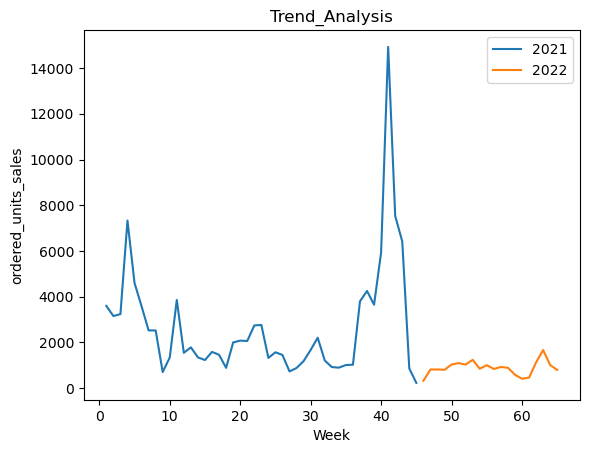

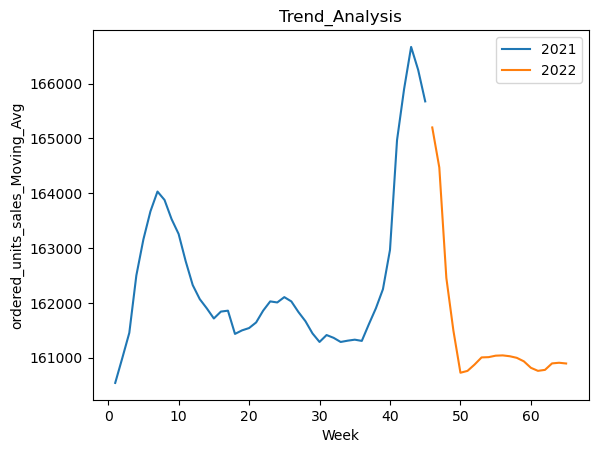

In [21]:
plotting(X_var='Week', y_var='ordered_units_sales', category_var='Year', data=data)
plotting(X_var='Week', y_var='ordered_units_sales_Moving_Avg', category_var='Year', data=data)

In [22]:
get_distribution('Year', data)

,count,Percentage
2021,45,0.692308
2022,20,0.307692
Total,65,1.000000


## Temporary price reduction (TPR)

TPR is a price decrease of greater than 5% of the regular price. The regular price is the median of all prices within 5% of the maximum price in the previous seven weeks. 
price_ = [max_price-threshold_price, max_price+threshold_price]

In [23]:
#Compute the weekly price
#ordered_revenue_sales
#ordered_units_sales
data['Price'] = data['ordered_revenue_sales']/data['ordered_units_sales']


In [24]:
value_list = data['Price'].tolist()

In [25]:
def create_dataframe(start_ind, end_ind, max_price_past_seven, threshold_price, price_lower_bound, price_upper_bound):
    global value_list
    result_check = pd.DataFrame({'Value':value_list[start_ind:end_ind]})
    result_check['Max_Price'] = max_price_past_seven
    result_check['Threshold'] = threshold_price
    result_check['Lower_Bound'] = price_lower_bound
    result_check['Upper_Bound'] = price_upper_bound
    result_check['Is_Within_Range'] = result_check['Value'].apply(lambda value: (value>=price_lower_bound and value<=price_upper_bound))
    return result_check

In [26]:
def compute_median(start_ind, batch_size):
    global value_list
    if(start_ind<batch_size):
        max_price_past_seven = max(value_list[:start_ind+1])
        begin = 0
    else:
        begin = start_ind-batch_size
        max_price_past_seven = max(value_list[begin:start_ind+1]) #-->O(N)

    threshold_price = 0.05*max_price_past_seven
    
    price_lower_bound, price_upper_bound = max_price_past_seven-threshold_price, max_price_past_seven + threshold_price

    #Within 5%
    price_range = [value for value in value_list[begin:start_ind+1] if(value>=price_lower_bound and value<=price_upper_bound)]
    result_check = create_dataframe(begin, start_ind+1, max_price_past_seven, threshold_price, price_lower_bound, price_upper_bound)
    median_price = np.median(price_range)
    
    #print(result_check)
    
    return median_price

In [27]:
def compute_regular_price(var='Price', data=data, batch_size=7):
    global value_list
    start_ind = 0
    end_ind = data.shape[0]
    value_list = data['Price'].tolist()
    
    regular_prices = [compute_median(start_ind, batch_size) for start_ind in range(end_ind)]
        
    data['Regular_Price'] = regular_prices

    return 'Regular_Price'

In [28]:
regular_price_var = compute_regular_price()

In [29]:
#data[['period', 'ordered_revenue_sales', 'ordered_units_sales', 'Price', regular_price_var]].head()
data[['period', 'ordered_revenue_sales', 'ordered_units_sales', 'Price', regular_price_var]].tail()

,period,ordered_revenue_sales,ordered_units_sales,Price,Regular_Price
60,2022-04-17,89826.88,463,194.010540,192.178506
61,2022-04-24,199011.47,1133,175.650018,192.178506
62,2022-05-01,296918.76,1669,177.902193,192.178506
63,2022-05-08,188644.78,1011,186.592265,191.506845
64,2022-05-15,157427.93,801,196.539238,194.010540


## Forecast

Give a forecast for next 52 weeks based on this data for the units, also do share your approach methodology. (Variable to forecast in the excel sheet is ordered_units_sales)

In [30]:
#Fit ARIMA Model
'''
AR:- Auto Regressive
A model that uses the dependent relationship between an observation and some number of lagged observations.

I:- Integrated
The number of times a raw observation is differenced with the observation at the previous time step. 
Purpose is to make the time series stationary.

MA:- Moving Average
A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

'''

def splitting_data(forecast_var, data):
    '''
    #data of the year 2021 for the purpose of training --> 69%
    #data of the year 2022 for the purpose of testing --> 31%
    '''
    #'ordered_units_sales', 'ordered_units_sales_Moving_Avg'
    time_series_data = data.set_index('period')
    
    training_data = time_series_data.loc[time_series_data['Year']==2021, forecast_var]
    testing_data = time_series_data.loc[time_series_data['Year']==2022, forecast_var]

    print(list(map(lambda df:df.shape, [training_data, testing_data])))

    return training_data, testing_data

In [31]:
def get_stats(array):
    total = np.sum(array)
    length = len(array)
    mean = total/length

    variance = (1/length)*np.sum([(x_i-mean)**2 for x_i in array])
    std_dev = np.sqrt(variance)

    return mean, variance, std_dev
    

In [32]:
#Model Training
class ARIMA_Modelling:
    '''
    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average.
    '''
    def __init__(self, p, d, q, train_data, test_data, model):
        self.p = p #AR --> Lag
        self.d = d #I  --> Differencing
        self.q = q #MA --> Moving Average
        self.train_data = train_data
        self.test_data = test_data
        self.model = model
        self.trained_model = ''
        self.model_summary = ''

    def plotting_residuals(self, residuals, kind=None, name=None):
        '''
        Input:
        residuals:-
        kind:- 

        Return:
        None
        '''
        if(kind):
            residuals.plot(kind=kind)
        else:
            residuals.plot()
        if(name):
            plt.title(name) 
        else:
            plt.title('Residual Errors')
        plt.show()

    def plotting(self, X_var, y_var, data_split_type, data):
        '''
        X_var:- The variable on the X-axis
        y_var:- The variable on the Y-axis
        data_split_type:- The variable representing the type of the split (Train/Test/Forecast)
        data:- The data containing the variables to be plotted
        '''
        fig, ax = plt.subplots()
        for split_type in data_split_type:
            df = data.loc[data['Data_Split_Type']==split_type, :]
            ax.plot(df[X_var], df[y_var], label=split_type)   
        
        ax.legend(data_split_type)
        plt.title('Trend_Analysis')
        plt.xlabel(X_var)
        plt.ylabel(y_var)
        plt.show()

    def evaluate_model(self, actual, predicted):
        actual_data_mean, actual_data_variance, actual_data_std_dev = get_stats(actual)
        predicted_data_mean, predicted_data_variance, predicted_data_std_dev = get_stats(predicted)
        
        RMSE = np.sqrt(mean_squared_error(actual, predicted))
        spread_stats = pd.DataFrame({'Indicator':['Actual Data', 'Predicted Data'],\
                                     'Mean':[actual_data_mean, predicted_data_mean],\
                                     'Variance':[actual_data_variance, predicted_data_variance],\
                                     'Standard Deviation':[actual_data_std_dev, predicted_data_std_dev]
                                    })
        print("Statistics:- \n")
        print(spread_stats)
        return RMSE
    
    def training(self):
        '''
        Train the model on the training data set         
        Return:
        trained_model:- The model object contating the parameters after training
        model_summary:- The meta data for the trained model
        '''
        history = [x for x in self.train_data]
        test = [x for x in self.test_data]
        test_predictions = []
        
        for t in range(len(test)):
            model = self.model(history, order=(self.p, self.d, self.q))
            trained_model = model.fit()
            output = trained_model.forecast()
            yhat=output[0]
            obs = test[t]
            test_predictions.append(yhat)
            history.append(obs)
            
        # summary of fit model
        model_summary = trained_model.summary()
        test_RMSE = self.evaluate_model(self.test_data.values, test_predictions)
        print("Test RMSE:- %.2f" %(test_RMSE))
        return trained_model, model_summary
    
    def forecast(self, forecast_count):
        # walk-forward validation
        all_data = pd.concat([self.train_data, self.test_data])
        forecast_predictions = pd.Series()
        
        for t in range(forecast_count):
            model = self.model(all_data, order=(self.p, self.d, self.q))
            trained_model = model.fit()
            output = trained_model.forecast()
            yhat=output[0]
            forecast_predictions = pd.concat([forecast_predictions, output])
            all_data = pd.concat([all_data, output])
            
        return forecast_predictions

    def combining_data(self, forecast_predictions):

        forecast_predictions.index.name = self.train_data.index.name
        forecast_predictions.name = self.train_data.name
        train_data, test_data, forecast_data = list(map(pd.DataFrame, [self.train_data, self.test_data, forecast_predictions]))
        
        train_data['Data_Split_Type'] = 'Train'
        test_data['Data_Split_Type'] = 'Test'
        forecast_data['Data_Split_Type'] = 'Forecast'
        
        combined_data = pd.concat([train_data, test_data, forecast_data])
        combined_data.reset_index(inplace=True)   
    
        #Create a variable for indicating Week
        combined_data['Week'] = range(1, combined_data.shape[0]+1)
        
        return combined_data
    
    def __call__(self):
        '''
        Invoke the necessary functions of the class via calling the object of the class.
        '''
        self.trained_model, self.model_summary = self.training()
       
        # line plot of residuals
        residuals = pd.DataFrame(self.trained_model.resid)
        # summary stats of residuals
        print("Residuals Stats:-\n{}" .format(residuals.describe()))
        
        for kind_, name_ in zip([None, 'kde'], [None, 'Density']):
            self.plotting_residuals(residuals, kind=kind_, name=name_)

        #Plotting all data
        forecast_predictions = self.forecast(52)

        results_combined_data = self.combining_data(forecast_predictions)
        return results_combined_data
        

### Using 'ordered_units_sales'

[(45,), (20,)]
Statistics:- 

        Indicator        Mean      Variance  Standard Deviation
0     Actual Data   889.40000  8.760774e+04          295.986047
1  Predicted Data  1100.46468  1.309226e+06         1144.214243
Test RMSE:- 1139.21
Residuals Stats:-
                 0
count    64.000000
mean     10.306603
std    1893.354938
min   -5197.897313
25%    -563.177034
50%     -29.053432
75%     201.680352
max    9791.443008


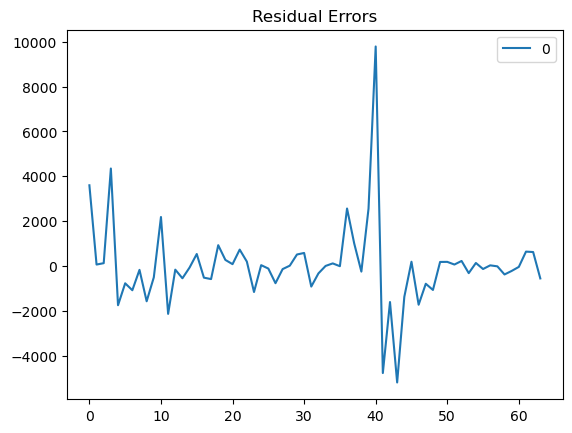

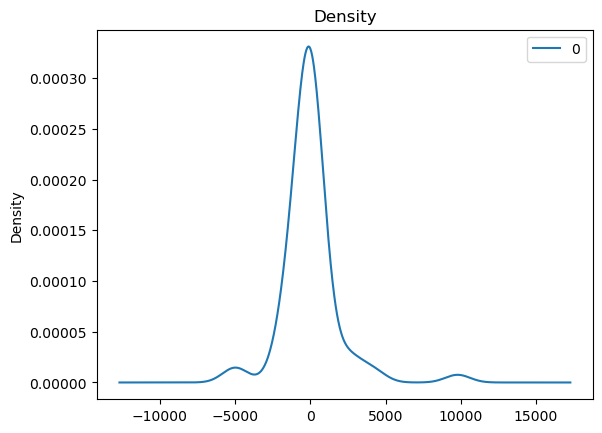

In [33]:
#Split the data 
training_data_raw_var, testing_data_raw_var = splitting_data(forecast_var='ordered_units_sales', data=data)

arima_obj_raw_var = ARIMA_Modelling(p=5, d=1, q=0, train_data=training_data_raw_var, test_data=testing_data_raw_var, model=ARIMA)
results_combined_data_raw_var = arima_obj_raw_var()

In [34]:
def combining_data(forecast_predictions):

    forecast_predictions.index.name = training_data.index.name
    forecast_predictions.name = training_data.name
    train_data, test_data, forecast_data = list(map(pd.DataFrame, [training_data, testing_data, forecast_predictions]))
    
    train_data['Data_Split_Type'] = 'Train'
    test_data['Data_Split_Type'] = 'Test'
    forecast_data['Data_Split_Type'] = 'Forecast'
    
    combined_data = pd.concat([train_data, test_data, forecast_data])
    combined_data.reset_index(inplace=True)   

    #Create a variable for indicating Week
    combined_data['Week'] = range(1, combined_data.shape[0]+1)
    return combined_data

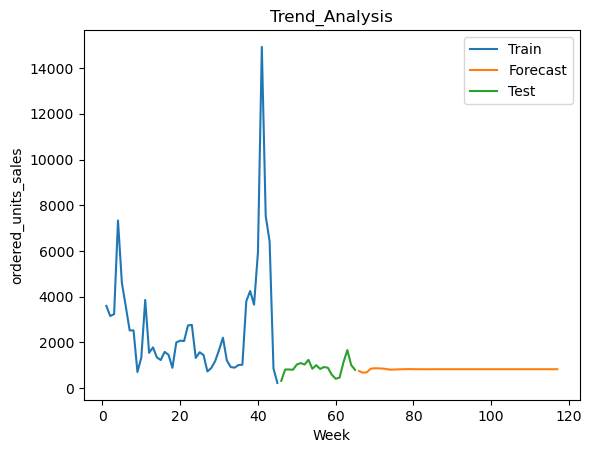

In [35]:
plotting(X_var='Week', y_var=training_data_raw_var.name, category_var='Data_Split_Type', data=results_combined_data_raw_var)

In [36]:
result_raw_var = adfuller(training_data_raw_var)

p_value = result_raw_var[1]

print('ADF Statistic: %f' % result_raw_var[0])
print('p-value: %f' % p_value)
print('Critical Values:')
for key, value in result_raw_var[4].items():
 print('\t%s: %.3f' % (key, value))

if(p_value<0.05):
    print("Reject H0") 
    print("Time series is stationary")

ADF Statistic: -3.354449
p-value: 0.012613
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607
Reject H0
Time series is stationary


## Using 'ordered_units_sales_Moving_Avg'

[(45,), (20,)]
Statistics:- 

        Indicator           Mean      Variance  Standard Deviation
0     Actual Data  161404.300000  1.455605e+06         1206.484416
1  Predicted Data  161621.871507  2.326091e+06         1525.152884
Test RMSE:- 550.49
Residuals Stats:-
                   0
count      64.000000
mean     2462.687465
std     20078.772037
min     -1965.813142
25%      -201.103710
50%       -20.445499
75%       147.831250
max    160539.914286


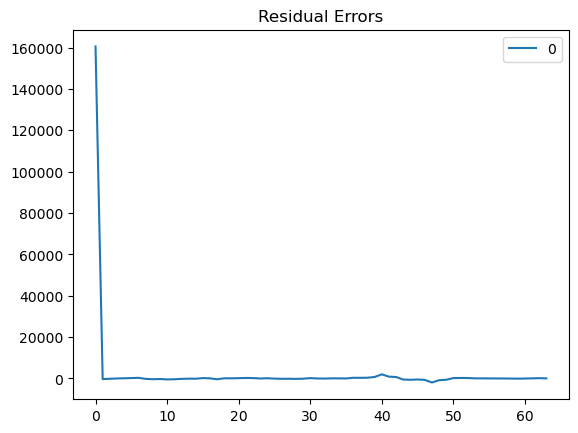

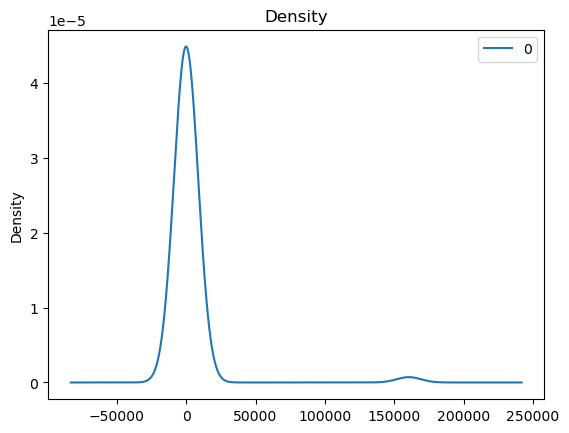

In [37]:
#Split the data 
training_data_moving_avg_var, testing_data_moving_avg_var = splitting_data(forecast_var='ordered_units_sales_Moving_Avg', data=data)

arima_obj_moving_avg_var = ARIMA_Modelling(p=5, d=1, q=0, train_data=training_data_moving_avg_var, test_data=testing_data_moving_avg_var, model=ARIMA)
results_combined_data_moving_avg_var = arima_obj_moving_avg_var()

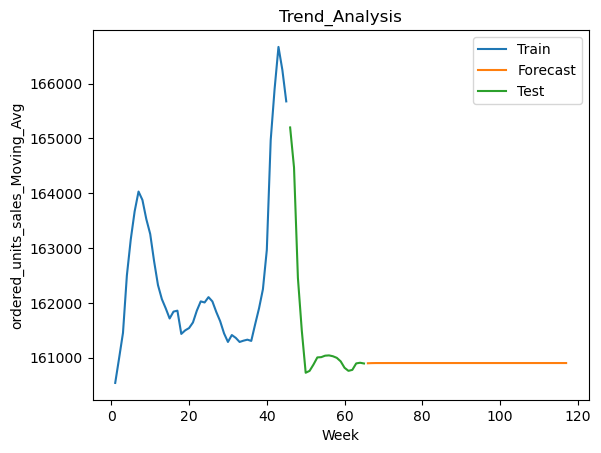

In [38]:
plotting(X_var='Week', y_var=training_data_moving_avg_var.name, category_var='Data_Split_Type', data=results_combined_data_moving_avg_var)

## Stationarity - Augmented Dickey-Fuller test

Stationay Time Series:- The statistical properties of the Time Series do not change over time.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

H0:- The time series is not stationary. It suggests the time series has a unit root.

H1:- The time series is stationary. 

In [40]:
result_moving_avg = adfuller(training_data_moving_avg_var)

p_value = result_moving_avg[1]

print('ADF Statistic: %f' % result_moving_avg[0])
print('p-value: %f' % p_value)
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

if(p_value<0.05):
    print("Reject H0") 
    print("Time series is stationary")
    

ADF Statistic: -2.964037
p-value: 0.038392
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607
Reject H0
Time series is stationary


## References

1. https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638

## Baseline Volume(/Expected Volume)

## Incremental Volumne
The incremental volume is the portion of total volume exceeding expected
volume, i.e., baseline volume. The incremental volume has been used to represent the
additional volume resulting from trade promotions, such as feature ads, display and
temporary price reduction (TPR).